This project tackles fine‑grained classification of spotted big cats (cheetah, jaguar, leopard), which are visually similar and often confused by humans. The aim is not only high accuracy but also interpretability: understanding which visual patterns the model uses (spots, rosettes, facial markings).

Import all required libraries

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation
from pathlib import Path

Load Data and split it into training and testing data.

Below cell uploads using kaggle api. Alternatively, you can download the dataset
from https://www.kaggle.com/datasets/sonilnegi/spotted-cats-images and load it directly.

In [189]:
# ! pip install kaggle

# from google.colab import drive
# drive.mount('/content/drive')

# ! mkdir ~/.kaggle
# # Upload your Kaggle API token to your google drive as json file and then change the path in the below line before running.
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download sonilnegi/spotted-cats-images
# ! unzip spotted-cats-images.zip


In [190]:
path = Path('/Users/sonil/Desktop/Image Classifier/spotted_cats_images/cats_projekat')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2, subset='training', seed=42)
validation_dataset = image_dataset_from_directory(path, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='validation',seed=42)

Found 2149 files belonging to 3 classes.
Using 1720 files for training.
Found 2149 files belonging to 3 classes.
Using 429 files for validation.


Checking distribution of images available for each image category.

In [191]:
cheetah_path = Path(path/'cheetahs')
jaguar_path = Path(path/'jaguars')
leopard_path = Path(path/'leopards')

# Count all files (not directories) in the folders
file_count = len([f for f in cheetah_path.iterdir() if f.is_file()])
print(f"Number of files in {cheetah_path.name}: {file_count}")
file_count = len([f for f in jaguar_path.iterdir() if f.is_file()])
print(f"Number of files in {jaguar_path.name}: {file_count}")
file_count = len([f for f in leopard_path.iterdir() if f.is_file()])
print(f"Number of files in {leopard_path.name}: {file_count}")

Number of files in cheetahs: 717
Number of files in jaguars: 704
Number of files in leopards: 728


A look at what the dataset looks like.


In [192]:
total = 0
for batch in train_dataset:
    total += batch[0].shape[0]
print(total)  # This will print 1540

1720


In [193]:
class_names = train_dataset.class_names
print(class_names)

['cheetahs', 'jaguars', 'leopards']


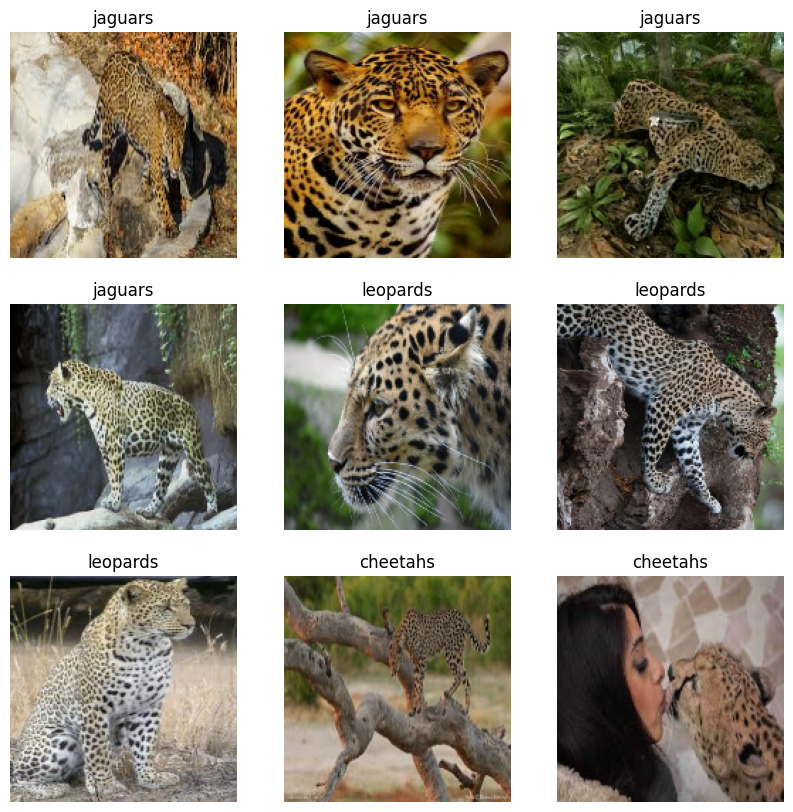

In [194]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [164]:
# One hot encoding

NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = train_dataset.map(one_hot_encode)
validation_dataset = validation_dataset.map(one_hot_encode)

Prefetching to improve efficiency by overlapping preprocessing and training on different batches.


In [195]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Defining data augmentation, normalization, and prefetching Pipeline

Random flips, rotations, zoom, contrast, and brightness help the model become robust to viewpoint changes and illumination, which is crucial for wildlife images taken in the wild.

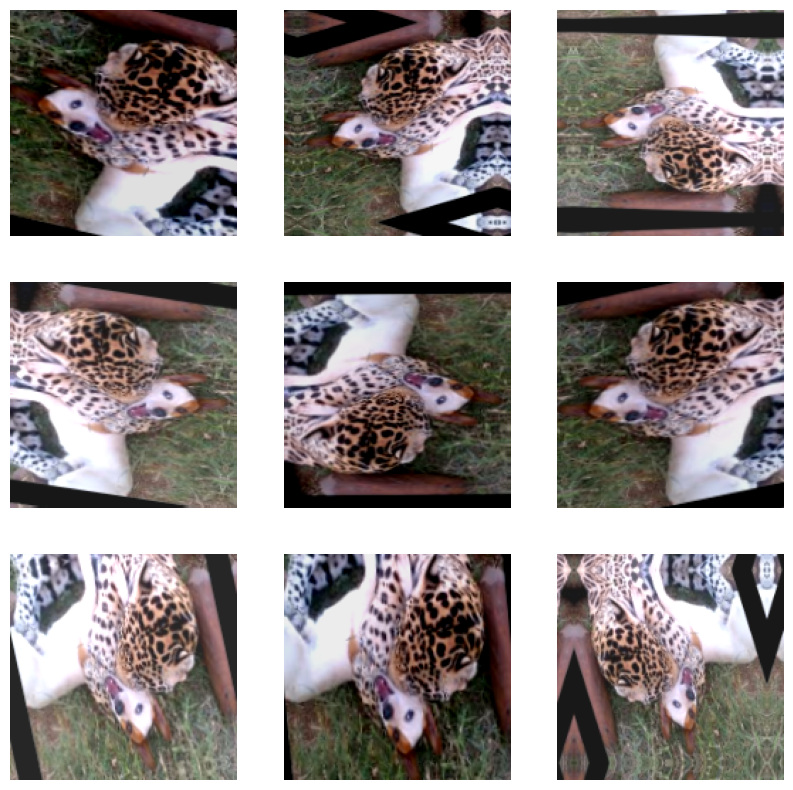

In [165]:
def data_augmenter():
    return tf.keras.Sequential([
        tfl.RandomFlip("horizontal"),
        tfl.RandomRotation(0.3),      # 0.2 → 0.3
        tfl.RandomZoom(0.2),
        tfl.RandomContrast(0.2),
        tfl.RandomBrightness(0.2)
    ])
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [166]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation

Time to bring in Mobilenet.

In [167]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [168]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [169]:
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Let us look at the last two layers.

In [170]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_15
predictions


Check Output shape

In [171]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


(32,1000) makes sense since 32 is batch size and Mobilenet originally has 1000 classes.

### Define a **CBAM attention module** for fine-grained recognition.

On top of MobileNetV2, a small attention block (CBAM) helps the model focus on the most useful features for telling these cats apart, like spot patterns and facial structure.

Channel attention learns which feature maps matter most; spatial attention learns where in the image those features appear, so the network can highlight the right regions of the cat instead of the background.

In [172]:
def cbam_block(inputs, reduction_ratio=8):
    # Channel attention branch
    avg_pool = tfl.GlobalAveragePooling2D(keepdims=True)(inputs)
    max_pool = tfl.GlobalMaxPooling2D(keepdims=True)(inputs)
    
    shared_layers = [
        tfl.Dense(inputs.shape[-1] // reduction_ratio, activation='relu'),
        tfl.Dense(inputs.shape[-1])
    ]
    
    avg_out = shared_layers[0](avg_pool)
    avg_out = shared_layers[1](avg_out)
    
    max_out = shared_layers[0](max_pool)
    max_out = shared_layers[1](max_out)
    
    channel_attention = tfl.Add()([avg_out, max_out])
    channel_attention = tfl.Activation('sigmoid')(channel_attention)
    channel_refined = tfl.Multiply()([inputs, channel_attention])
    
    # Spatial attention branch
    avg_pool_spatial = tfl.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = tfl.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    
    spatial_concat = tfl.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = tfl.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_concat)
    
    output = tfl.Multiply()([channel_refined, spatial_attention])
    return output


### MobileNetV2

MobileNetV2 is used as a lightweight backbone pretrained on ImageNet. Its final feature map goes through the attention block, then a global pooling layer and a 3‑way classifier for cheetah, jaguar, and leopard.

At first the backbone is frozen and only the new attention + classifier layers are trained, so the model can adapt quickly without destroying useful pretrained features.

In [173]:
def bigcat_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    #to make sure the model expects RGB images as input.
    input_shape = image_shape + (3,)

    #load mobilenet_v2 as base feature extractor without including final classification layers.
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    #attention block
    x = cbam_block(x, reduction_ratio=16)

    # add the new classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.4 to avoid overfitting
    x = Dropout(0.4)(x)
    # use a prediction layer with threee neurons (three classes)
    outputs = tf.keras.layers.Dense(3)(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [174]:
model2 = bigcat_model(IMG_SIZE)


In [175]:
model2.summary()

Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 160, 160,  │          0 │ input_layer_22[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 160, 160,  │          0 │ sequential_6[0][… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 160, 160,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 5, 5,      │  2,257,984 │ subtract_2[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 1,      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1, 1,      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1, 80)  │    102,480 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1, 1,      │    103,680 │ dense_15[0][0],   │
│                     │ 1280)             │            │ dense_15[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1,      │          0 │ dense_16[0][0],   │
│                     │ 1280)             │            │ dense_16[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 1,      │          0 │ add_2[0][0]       │
│ (Activation)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 5, 5,      │          0 │ mobilenetv2_1.00… │
│ (Multiply)          │ 1280)             │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 5, 5, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 5, 5, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5, 5, 2)   │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 5, 1)   │         99 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 5, 5,      │          0 │ multiply_4[0][0], │
│ (Multiply)          │ 1280)             │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_5[0][0]

 Total params: 2,468,086 (9.42 MB)

 Trainable params: 210,102 (820.71 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Configure the model before training. (which optimizer, loss function and metric to use.)

The learning rate is kept low (1e‑4) to make fine‑tuning stable on a pretrained network.

In [176]:
base_learning_rate = 0.0001

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Start training and track the progress.

In [177]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 678ms/step - accuracy: 0.4244 - loss: 1.0831 - val_accuracy: 0.5455 - val_loss: 1.0368
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.5558 - loss: 0.9784 - val_accuracy: 0.6177 - val_loss: 0.9261
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6494 - loss: 0.8511 - val_accuracy: 0.6737 - val_loss: 0.8000
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 705ms/step - accuracy: 0.6959 - loss: 0.7409 - val_accuracy: 0.6993 - val_loss: 0.7111
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 616ms/step - accuracy: 0.7151 - loss: 0.6765 - val_accuracy: 0.7273 - val_loss: 0.6592


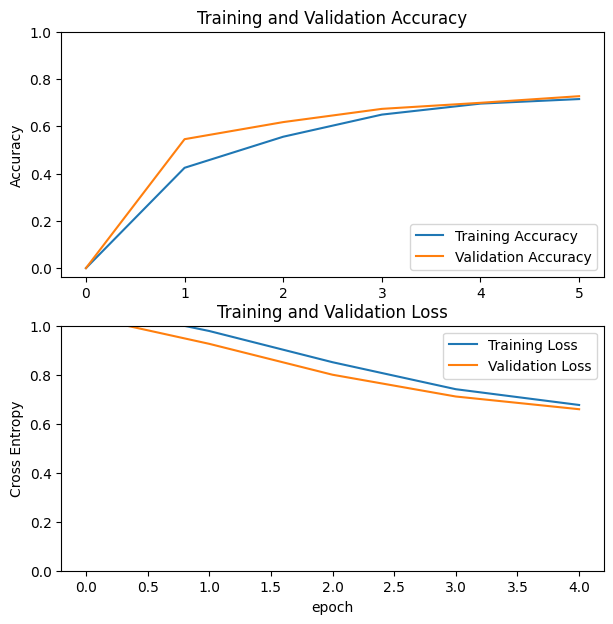

In [178]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Check on test data

In [179]:
path1 = Path('/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.8054 - loss: 0.5120
Test Accuracy : 0.805383026599884


**85.71% test accuracy**.


Let's see if we can improve this by fine tuning the top layers

we will unfreeze the top part of MobileNetV2 and fine‑tune it with a smaller learning rate so the high‑level features adapt to spotted cats.

In [180]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
# Define a loss function
loss_function= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [181]:

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - accuracy: 0.7215 - loss: 0.6544 - val_accuracy: 0.7156 - val_loss: 0.6562
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - accuracy: 0.7384 - loss: 0.6269 - val_accuracy: 0.7110 - val_loss: 0.6554
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step - accuracy: 0.7372 - loss: 0.6223 - val_accuracy: 0.7110 - val_loss: 0.6516
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 480ms/step - accuracy: 0.7407 - loss: 0.6237 - val_accuracy: 0.7133 - val_loss: 0.6474
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.7343 - loss: 0.6208 - val_accuracy: 0.7133 - val_loss: 0.6445
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.7273 - loss: 0.6266 - val_accuracy: 0.7156 - val_loss: 0.6404


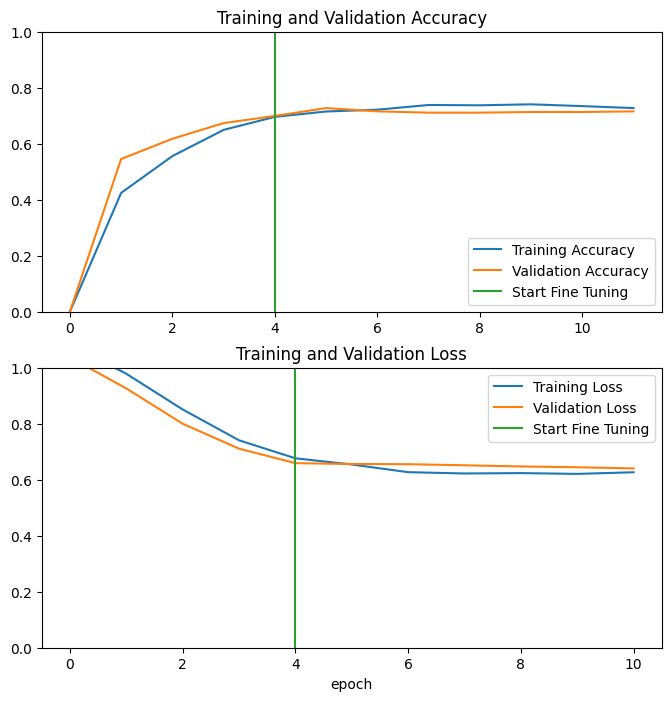

In [182]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [183]:
path1 = Path('/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a')

IMG_SIZE = (160, 160)
test_dataset = image_dataset_from_directory(path1, shuffle=False, image_size=IMG_SIZE,  seed=42)
class_names2 = test_dataset.class_names
print(class_names2)

# One hot encoding of test data
NUM_CLASSES = 3  # cheetahs, jaguars, leopards

def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

test_dataset = test_dataset.map(one_hot_encode)
from pathlib import Path
from PIL import Image

test_dir = path1
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except Exception as e:
                print(f"Removing corrupted file: {img_path}")
                img_path.unlink()  # Remove the file
import imghdr
from pathlib import Path

test_dir = path1

for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.iterdir():
            img_type = imghdr.what(img_path)
            if img_type not in ['jpeg', 'png', 'bmp', 'gif']:
                print(f"Removing non-image or unsupported file: {img_path}")
                img_path.unlink()
results = model2.evaluate(test_dataset)
print("Test Accuracy :",results[1])

Found 483 files belonging to 3 classes.
['cheetahs', 'jaguars', 'leopards']
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step - accuracy: 0.8095 - loss: 0.4809
Test Accuracy : 0.8095238208770752


**87.37% Test Accuracy.**

An improvement of around 1.5 percent in accuracy through fine-tuning.

In [229]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def make_prediction(image_path):
    img = load_img(image_path, target_size=(160, 160))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # NOT /255.0

    preds = model2.predict(img_array)
    probs = tf.nn.softmax(preds, axis=1).numpy()[0]
    print("probs:", probs, "argmax:", probs.argmax())
    idx = np.argmax(probs)
    label = class_names[idx]
    prob = probs[idx]
    print(f"Predicted class: {label} ({prob*100:.2f}% confidence)")
    
    # Plot images
    plt.figure(figsize=(10, 5)) # Adjusted figure size for better display
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')

    plt.show()

In [226]:

print(class_names)


['cheetahs', 'jaguars', 'leopards']


In [227]:
print("class_names:", class_names)

test_img = '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a/leopards/1dbf0b07-598a-453b-b2a7-a6fe61ff3678.jpg'
img = load_img(test_img, target_size=(160, 160))
arr = img_to_array(img)[None] / 255.0

preds = model2.predict(arr)
print("raw preds:", preds)
print("argmax index:", np.argmax(preds, axis=1)[0])


class_names: ['cheetahs', 'jaguars', 'leopards']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
raw preds: [[ 0.8424582  -0.13023849  0.3474604 ]]
argmax index: 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
probs: [0.53204274 0.16032745 0.3076298 ] argmax: 0
Predicted class: cheetahs (53.20% confidence)


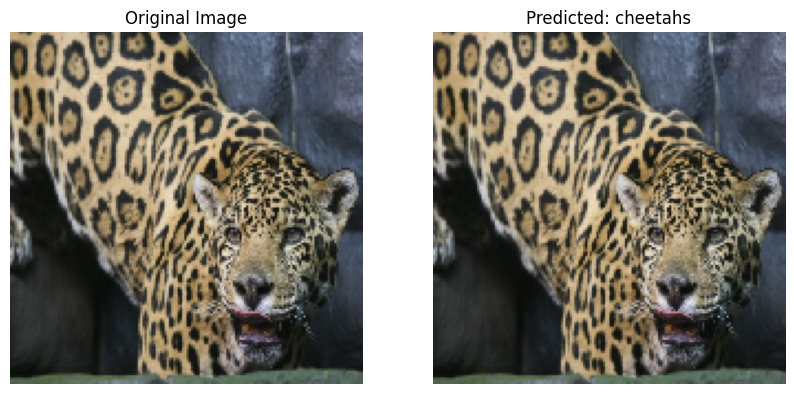

In [230]:
img_path = '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a/jaguars/jaguar_141_resized.jpg'
make_prediction(img_path)

# Grad-CAM in action!

Grad‑CAM is used to visualize which regions of the image drive each prediction.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# same size you use in training
IMG_SIZE = (160, 160)

# plain backbone for Grad-CAM only
gradcam_backbone = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# pick a stable last conv layer from the official Keras example
target_layer_name = "Conv_1"   # this exists in MobileNetV2
target_layer = gradcam_backbone.get_layer(target_layer_name)

# add a simple global pool + dense head (for 3 classes) just for Grad-CAM
x = target_layer.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

gradcam_model = tf.keras.Model(inputs=gradcam_backbone.input, outputs=outputs)


In [ ]:
def generate_gradcam_tf(model, img_path, class_names, target_layer_name="Conv_1"):
    # 1) Build grad model on this standalone model
    target_layer = model.get_layer(target_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[target_layer.output, model.output]
    )

    # 2) Load & preprocess
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # 3) Forward + gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)          # (1,H,W,C)
    if grads is None:
        print("Gradients are None")
        return None, None, None, None

    # channel importance
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))    # (C,)
    conv_outputs = conv_outputs[0]                     # (H,W,C)
    cam = tf.reduce_sum(conv_outputs * weights, axis=-1)  # (H,W)

    # 4) Normalize
    cam = tf.nn.relu(cam)
    cam_max = tf.reduce_max(cam)
    if cam_max > 0:
        cam = cam / cam_max
    cam = cam.numpy()

    # 5) Resize + overlay
    cam = cv2.resize(cam, IMG_SIZE)
    cam = np.uint8(255 * cam)
    heatmap_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, IMG_SIZE)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    overlay = 0.3 * heatmap_color + 0.7 * orig
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    pred_index = int(pred_index.numpy())
    conf = float(predictions[0][pred_index].numpy())
    pred_name = class_names[pred_index]
    return overlay, pred_index, conf, pred_name


## Where do the eyes linger?


Each panel shows the original image with a Grad‑CAM heatmap on top; warmer colors mean the model is paying more attention there.

/Users/sonil/Desktop/Image Classifier/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1938']
Received: inputs=Tensor(shape=(1, 160, 160, 3))
  warnings.warn(msg)


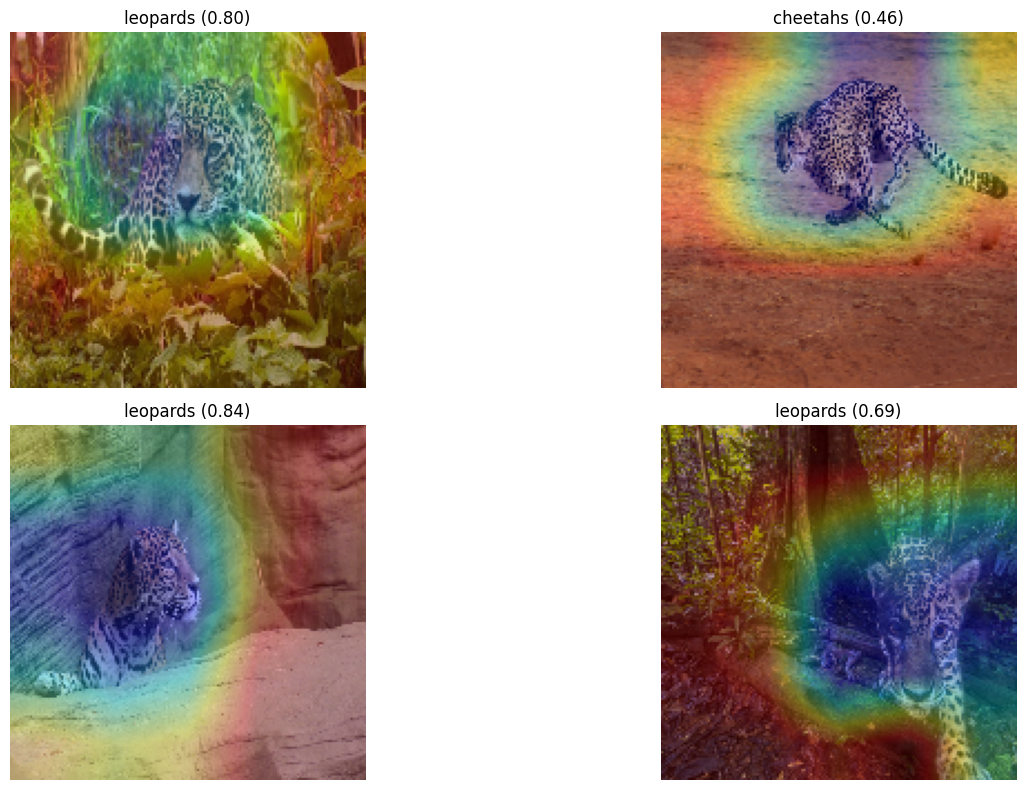

In [ ]:
import matplotlib.pyplot as plt

test_paths = [
    '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a/leopards/4725173f-98be-4073-afaf-bc3769b44d78.jpg',
    '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/a/cheetahs/dac28414-eccb-491e-9d7b-b63f0cd92b59.jpg',
    '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/cats_projekat/jaguars/Bella.jpg',
    '/Users/sonil/Desktop/Image Classifier/spotted_cats_images/cats_projekat/jaguars/Medium_WW2120938.jpg'
]

plt.figure(figsize=(16, 8))

for i, img_path in enumerate(test_paths):
    vis, pred_cls, conf, pred_name = generate_gradcam_tf(
        gradcam_model,
        img_path,
        class_names,
        target_layer_name="Conv_1"
    )
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(vis)
    plt.title(f"{pred_name} ({conf:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()


### It appears that our model is looking in the right places to classify the image.